In [78]:
%cd /home/ltchen/gnnpp
import sys
import os
import pytorch_lightning as L
import torch
import torch_geometric
import json
import copy

from typing import Tuple
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import scatter
from torch.nn import Linear, ModuleList, ReLU
from torch_geometric.loader import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.optim import AdamW
from pytorch_lightning.loggers import WandbLogger

from models.loss import NormalCRPS
from models.model_utils import MakePositive, EmbedStations
from utils.data import (
    load_dataframes,
    load_distances,
    normalize_features_and_create_graphs,
    rm_edges,
    summary_statistics,
)
from exploration.graph_creation import *
from models.graphensemble.multigraph import *
import shap
from torch_geometric.explain import GNNExplainer

/home/ltchen/gnnpp


## Retrieve trained model

In [84]:
leadtime = "24h"
data_type = "f"

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
DIRECTORY = os.getcwd()
SAVEPATH = os.path.join(DIRECTORY, f"leas_final_models/gnn_run4_{leadtime}/models")
JSONPATH = os.path.join(DIRECTORY, f"trained_models/best_{leadtime}/params.json")

with open(JSONPATH, "r") as f:
    print(f"[INFO] Loading {JSONPATH}")
    args_dict = json.load(f)
config = args_dict

# from gnn_run3 ###############################
max_epoch_list = {
    'g1': 31,
    'g2': 26,
    'g3': 31,
    'g4': 32,
    'g5': 23,
}

[INFO] Loading /home/ltchen/gnnpp/trained_models/best_24h/params.json


In [81]:
dataframes = load_dataframes(mode="eval", leadtime=leadtime)
dataframes = summary_statistics(dataframes)


[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f


In [82]:
graph_name = "g1"
graphs1_train_rf, tests1 = normalize_features_and_create_graphs1(df_train=dataframes['train'], df_valid_test=[dataframes['test_rf'], dataframes['test_f']], station_df=dataframes['stations'], attributes=["geo"], edges=[("geo", 100)], sum_stats = True)
graphs1_test_rf, graphs1_test_f = tests1

g1_train_loader = DataLoader(graphs1_train_rf, batch_size=config['batch_size'], shuffle=True)
g1_test_f_loader = DataLoader(graphs1_test_f, batch_size=config['batch_size'], shuffle=False)
g1_test_rf_loader = DataLoader(graphs1_test_rf, batch_size=config['batch_size'], shuffle=False)

train_loader = g1_train_loader
test_f_loader = g1_test_f_loader
test_rf_loader = g1_test_rf_loader
test_loader = [test_f_loader, test_rf_loader]

emb_dim = 20
in_channels = graphs1_train_rf[0].x.shape[1] + emb_dim - 1
edge_dim = graphs1_train_rf[0].num_edge_features
max_epochs = max_epoch_list[graph_name]

[INFO] Normalizing features...
fit_transform
transform 1
transform 2


100%|██████████| 730/730 [00:02<00:00, 286.08it/s]


In [83]:
PROJECTNAME = "gnn_run4"
FILENAME = graph_name + "_run_" + leadtime
TRAINNAME = graph_name + "_train_run_" + leadtime
CKPT_PATH = os.path.join(SAVEPATH, TRAINNAME + '.ckpt')
RESULTPATH = os.path.join(DIRECTORY, f"leas_trained_models/best_{leadtime}/best_{leadtime}_{graph_name}")

multigraph = Multigraph.load_from_checkpoint(
    CKPT_PATH,
    embedding_dim=emb_dim,
    edge_dim=edge_dim,
    in_channels=in_channels,
    hidden_channels_gnn=config['gnn_hidden'],
    out_channels_gnn=config['gnn_hidden'],
    num_layers_gnn=config['gnn_layers'],
    heads=config['heads'],
    hidden_channels_deepset=config['gnn_hidden'],
    optimizer_class=AdamW,
    optimizer_params=dict(lr=config['lr']),
)
torch_geometric.compile(multigraph)
multigraph.eval()
batch = next(iter(train_loader))
batch = batch.to("cuda")
multigraph.to("cuda")
multigraph.forward(batch)
trainer = L.Trainer(log_every_n_steps=1, accelerator="gpu", devices=1, enable_progress_bar=True)
# trainer = L.Trainer()

/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/torch_geometric/_compile.py:34: UserWarning: 'torch_geometric.compile' is deprecated in favor of 'torch.compile'
  warnings.warn("'torch_geometric.compile' is deprecated in favor of "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
data_list = ["f", "rf"]
for data, tl in zip(data_list, test_loader):
    preds_list = []
    preds = trainer.predict(model=multigraph, dataloaders=[tl]) # 92 x 976 x 2 forecasts with mu and sigma of 122 stations
    print(preds[0].shape)
    # preds = [prediction.reshape(1, 122, 2).mean(axis=0) for prediction in preds]
    #ACHTUNG - reshape(1, 122, 2) mit 1 statt 5!
    preds = torch.cat(preds, dim=0)
    preds_list.append(preds)

    targets = dataframes[f"test_{data}"][1]
    targets = torch.tensor(targets.t2m.values) - 273.15

    stacked = torch.stack(preds_list)
    final_preds = torch.mean(stacked, dim=0)

    res = multigraph.loss_fn.crps(final_preds, targets)
    print("#############################################")
    print("#############################################")
    print(f"final crps: {res.item()}")
    print("#############################################")
    print("#############################################")

    os.makedirs(RESULTPATH, exist_ok=True)

    df = pd.DataFrame(np.concatenate([targets.view(-1, 1), final_preds], axis=1), columns=["t2m", "mu", "sigma"])
    df.to_csv(os.path.join(RESULTPATH, f"{data}_{FILENAME}_results.csv"), index=False)

    # Create Log File ###############################################################
    log_file = os.path.join(RESULTPATH, f"{data}.txt")
    with open(log_file, "w") as f:
        f.write(f"Data: {data}\n")
        f.write(f"Leadtime: {leadtime}\n")
        f.write(f"Final crps: {res.item()}")

You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 92/92 [00:01<00:00, 81.27it/s]
torch.Size([976, 2])
#############################################
#############################################
final crps: 0.6755105734340946
#############################################
#############################################


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 92/92 [00:01<00:00, 78.49it/s]
torch.Size([976, 2])
#############################################
#############################################
final crps: 0.698142507132079
#############################################
#############################################


## Permutation Importance

In [ ]:
# load t2m_labels, mu, sigma from csv
# get feature_names and shuffle features
# create graph with shuffled features
# load into test_loader
# evaluate ensemble by calcualting crps
# save results in csv
# Kann ich permutation importance auch auf edge features anwenden? => edge attributes shufflen?

In [86]:
#  = dataframes['test_f'][0].columns.tolist() # - ['time', 'number']
feature_names = [f for f in dataframes['test_f'][0].columns.tolist() if f not in ['time', 'number']] # dropped time and number: len - 65
feature_names
# len(feature_names)

['station_id',
 'model_orography',
 'station_altitude',
 'station_latitude',
 'station_longitude',
 'cape_mean',
 'cape_std',
 'sd_mean',
 'sd_std',
 'stl1_mean',
 'stl1_std',
 'swvl1_mean',
 'swvl1_std',
 't2m_mean',
 't2m_std',
 'tcc_mean',
 'tcc_std',
 'tcw_mean',
 'tcw_std',
 'tcwv_mean',
 'tcwv_std',
 'u10_mean',
 'u10_std',
 'u100_mean',
 'u100_std',
 'v10_mean',
 'v10_std',
 'v100_mean',
 'v100_std',
 'vis_mean',
 'vis_std',
 'cp6_mean',
 'cp6_std',
 'mn2t6_mean',
 'mn2t6_std',
 'mx2t6_mean',
 'mx2t6_std',
 'p10fg6_mean',
 'p10fg6_std',
 'slhf6_mean',
 'slhf6_std',
 'sshf6_mean',
 'sshf6_std',
 'ssr6_mean',
 'ssr6_std',
 'ssrd6_mean',
 'ssrd6_std',
 'str6_mean',
 'str6_std',
 'strd6_mean',
 'strd6_std',
 'tp6_mean',
 'tp6_std',
 'z_mean',
 'z_std',
 'q_mean',
 'q_std',
 'u_mean',
 'u_std',
 'v_mean',
 'v_std',
 't_mean',
 't_std',
 'cos_doy',
 'sin_doy']

In [57]:
graphs1_test_f[0].x[:,63]
graphs1_test_f[100].x[:,63] # alle am gleichen Tag, daher alle gleich

tensor([-0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.16

In [135]:
torch.Tensor(dataframes[f"test_{data}"][1]["t2m"]).unsqueeze(1).shape

torch.Size([89060, 1])

In [123]:
def split_graph1(graph) -> List[torch_geometric.data.Data]:
    """Splits a graph which is created using 51 ensemble members into 5 subgraphs,
    each containing 10 or 11 ensemble members.

    Args:
        graph (torch_geometric.data.Data): the graph to be split
    """
    perm = torch.randperm(51) * 122  # First node of each ensemble member
    index = perm[:, None] + torch.arange(122)  # Add the node indices to each ensemble member
    print(index.shape)
    set1 = index[:10]
    set2 = index[10:20]
    set3 = index[20:30]
    set4 = index[30:40]
    set5 = index[40:]  # Has 11 elements
    print(set1.shape)
    print(set1.flatten().shape)
    sets = [
        set1,
        set2,
        set3,
        set4,
        set5,
    ]  # Each set contains a list of station indices corresponding to 10 (or 11) ensemble members
    print(set1)
    graphs = []
    for s in sets:
        graphs.append(graph.subgraph(s.flatten()))
    return graphs

In [137]:
# try for one feature first!!
graphs1_test = graphs1_test_f
feature_idx = [i for i, value in enumerate(feature_names) if value in ['station_altitude']]

xs = [g.x for g in graphs1_test]

xs = torch.stack(xs)

xs_permuted = xs[..., feature_idx]
xs_shuffled = shuffle_features(xs=xs, feature_permute_idx=feature_idx)
graphs_test_shuffled = []


i = 0
for graph, shuffled_feature in zip(graphs1_test, xs_shuffled):
    graph_copy = copy.deepcopy(graph)
    graph_copy.x = shuffled_feature
    graphs_test_shuffled.append(graph_copy) # len 732

# split graphs if "f" because too many ensemble members # not used because we only use summary_statistics
# if data_type == "f":
#     graphs_split = [split_graph1(g) for g in graphs_test_shuffled] # for each of the 732 graphs split the graph in
#     graphs_test_shuffled = [g for sublist in graphs_split for g in sublist]

bs = 1 # if data_type == "rf" else 5
shuffled_test_loader = DataLoader(graphs_test_shuffled, batch_size=bs, shuffle=False)

preds = trainer.predict(model=multigraph, dataloaders=[shuffled_test_loader])

# if data_type == "f":
#     preds = [prediction.reshape(5, 122, 2).mean(axis=0) for prediction in preds]
targets = dataframes[f"test_{data}"][1]
targets = torch.tensor(targets.t2m.values) - 273.15

print(f"\033[91m len(preds):{len(preds)} \033[0m")
preds = torch.cat(preds, dim=0)
print(f"\033[91m Preds.shape:{preds.shape} \033[0m")
print(f"\033[91m Targets.shape:{targets.shape} \033[0m")
res = multigraph.loss_fn.crps(preds, targets)
score = res.item()

print(f"########### targets ############\n{targets}")
print(f"########### preds ############\n{preds}")
print(f"########### RES ############\n{res}")
print(f"########### SCORE ############\n{score}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 167.68it/s]
 len(preds):730 
 Preds.shape:torch.Size([89060, 2]) 
 Targets.shape:torch.Size([89060]) 
########### targets ############
tensor([ 5.5000,  2.1000,  6.6000,  ...,  3.2000, -2.5000, -4.3000],
       dtype=torch.float64)
########### preds ############
tensor([[4.3365, 0.6600],
        [1.1003, 0.6375],
        [4.6257, 0.5853],
        ...,
        [4.7719, 1.0933],
        [3.4884, 0.8844],
        [0.2549, 0.8322]])
########### RES ############
0.862702886052042
########### SCORE ############
0.862702886052042


In [160]:
values = feature_names
grouped = []
i = 0
while i < len(values):
    if values[i] == 'model_orography':
        if i + 1 < len(values) and 'station_altitude' in values[i+1]:
            grouped.append([values[i], values[i+1]])
            i += 2
        else:
            grouped.append([values[i]])
            i += 1
    if values[i] == 'cos_doy':
        if i + 1 < len(values) and 'sin_doy' in values[i+1]:
            grouped.append([values[i], values[i+1]])
            i += 2
        else:
            grouped.append([values[i]])
            i += 1
    elif i + 1 < len(values) and values[i+1] == values[i].replace('mean', 'std'):
        grouped.append([values[i], values[i+1]])
        i += 2
    else:
        grouped.append([values[i]])
        i += 1

print(grouped)

[['station_id'], ['model_orography', 'station_altitude'], ['station_latitude'], ['station_longitude'], ['cape_mean', 'cape_std'], ['sd_mean', 'sd_std'], ['stl1_mean', 'stl1_std'], ['swvl1_mean', 'swvl1_std'], ['t2m_mean', 't2m_std'], ['tcc_mean', 'tcc_std'], ['tcw_mean', 'tcw_std'], ['tcwv_mean', 'tcwv_std'], ['u10_mean', 'u10_std'], ['u100_mean', 'u100_std'], ['v10_mean', 'v10_std'], ['v100_mean', 'v100_std'], ['vis_mean', 'vis_std'], ['cp6_mean', 'cp6_std'], ['mn2t6_mean', 'mn2t6_std'], ['mx2t6_mean', 'mx2t6_std'], ['p10fg6_mean', 'p10fg6_std'], ['slhf6_mean', 'slhf6_std'], ['sshf6_mean', 'sshf6_std'], ['ssr6_mean', 'ssr6_std'], ['ssrd6_mean', 'ssrd6_std'], ['str6_mean', 'str6_std'], ['strd6_mean', 'strd6_std'], ['tp6_mean', 'tp6_std'], ['z_mean', 'z_std'], ['q_mean', 'q_std'], ['u_mean', 'u_std'], ['v_mean', 'v_std'], ['t_mean', 't_std'], ['cos_doy', 'sin_doy']]


In [161]:
# try for all features (in pairs) - alt and orog, mean and std
feature_list = grouped
graphs1_test = graphs1_test_f

rows = []

for f_list in feature_list:
    feature_idx = [i for i, value in enumerate(feature_names) if value in f_list]
    xs = [g.x for g in graphs1_test]
    xs = torch.stack(xs)

    xs_permuted = xs[..., feature_idx]
    xs_shuffled = shuffle_features(xs=xs, feature_permute_idx=feature_idx)
    graphs_test_shuffled = []


    i = 0
    for graph, shuffled_feature in zip(graphs1_test, xs_shuffled):
        graph_copy = copy.deepcopy(graph)
        graph_copy.x = shuffled_feature
        graphs_test_shuffled.append(graph_copy) # len 732

    # split graphs if "f" because too many ensemble members # not used because we only use summary_statistics
    # if data_type == "f":
    #     graphs_split = [split_graph1(g) for g in graphs_test_shuffled] # for each of the 732 graphs split the graph in
    #     graphs_test_shuffled = [g for sublist in graphs_split for g in sublist]

    bs = 1 # if data_type == "rf" else 5
    shuffled_test_loader = DataLoader(graphs_test_shuffled, batch_size=bs, shuffle=False)

    preds = trainer.predict(model=multigraph, dataloaders=[shuffled_test_loader])

    # if data_type == "f":
    #     preds = [prediction.reshape(5, 122, 2).mean(axis=0) for prediction in preds]
    targets = dataframes[f"test_{data}"][1]
    targets = torch.tensor(targets.t2m.values) - 273.15

    # print(f"\033[91m len(preds):{len(preds)} \033[0m")
    preds = torch.cat(preds, dim=0)
    # print(f"\033[91m Preds.shape:{preds.shape} \033[0m")
    # print(f"\033[91m Targets.shape:{targets.shape} \033[0m")
    res = multigraph.loss_fn.crps(preds, targets)
    score = res.item()

    rows.append({
        'Feature': f_list,
        'CRPS': score,
    })
stored_pi = pd.DataFrame(rows)
print(stored_pi)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 171.96it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 159.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 158.15it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 178.16it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 162.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 157.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 168.34it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 178.29it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 183.52it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 165.77it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 168.15it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 185.27it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 178.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 176.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 166.15it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 200.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 177.16it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 154.29it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 153.71it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 170.67it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 158.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 162.72it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 157.59it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 163.98it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 178.21it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 170.26it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 170.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 160.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 161.49it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 158.01it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 191.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 177.29it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 173.36it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 169.28it/s]
                                Feature      CRPS
0                          [station_id]  1.536439
1   [model_orography, station_altitude]  0.918685
2                    [station_latitude]  0.803999
3                   [station_longitude]  0.723477
4                 [cape_mean, cape_std]  0.677204
5                     [sd_mean, sd_std]  0.693392
6                 [stl1_mean, stl1_std]  0.943155
7               [swvl1_mean, swvl1_std]  0.735921
8                   [t2m_mean, t2m_std]  2.245292
9                   [tcc_mean, tcc_std]  0.690027
10                  [tcw_mean, tcw_std]  0.744246
11                [tcwv_mean, tcwv_std]  0.735172
12                  [u10_mean, u10_std]  0.721123
13                [u100_mean, u100_std]  0.755403
14                  [v10_mean, v10_std]  0.708698
15                [v100_mean, v100_std]  0.711448
16                  [vis_mean, vis_std]  0.692067
17                  [cp6

0.6755105734340946

In [170]:
stored_pi.to_csv(os.path.join(RESULTPATH, f'leas_permutation_importance_{data_type}.csv'), index=False)
crps_value = float([line for line in open(os.path.join(RESULTPATH, f"{data}.txt")) if line.startswith('Final crps:')][0].split(':')[1])


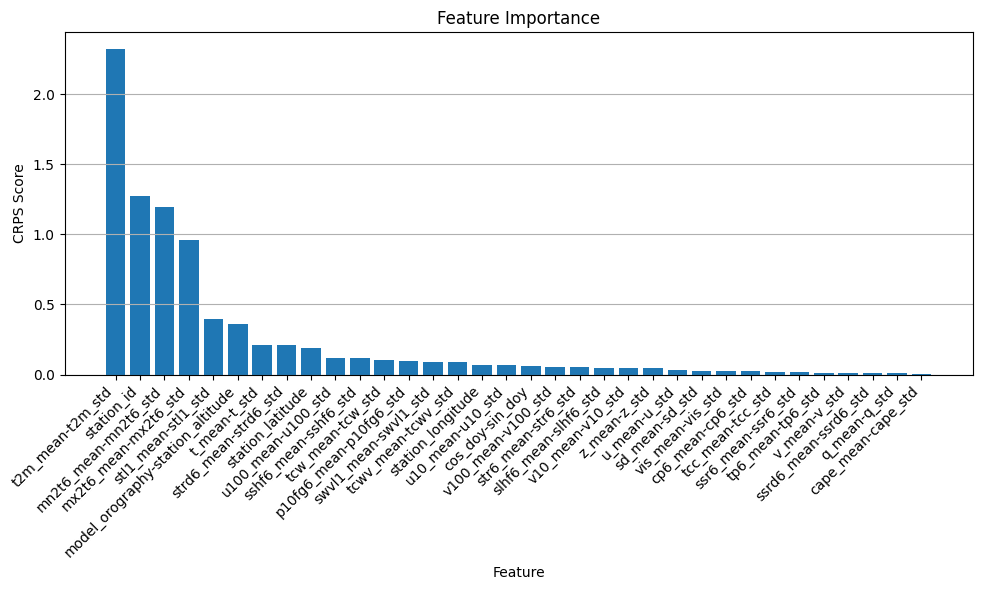

In [173]:
sorted_stored_pi = stored_pi.sort_values(by='CRPS', ascending=False)
sorted_stored_pi['Feature'] = sorted_stored_pi['Feature'].apply(lambda x: '-'.join(x) if isinstance(x, list) else str(x))
sorted_stored_pi['Relative'] = (sorted_stored_pi['CRPS'] - crps_value)/ crps_value
plt.figure(figsize=(10, 6))
plt.bar(sorted_stored_pi['Feature'], sorted_stored_pi['Relative'])

plt.xlabel('Feature')
plt.ylabel('CRPS Score')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')  # Rotate x labels so they don't overlap
plt.grid(axis='y')  # Horizontal grid lines
plt.tight_layout()  # Fit everything nicely
plt.show()

## Shapley value